In [22]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import math
import json
import datetime
from pandas.io.json import json_normalize
matplotlib.rc('font',family='AppleGothic')

In [3]:
json_file = open("1_20151101_heart.json", 'r')
json_data = json_file.read()
json_file.close()
heart_json = json.loads(json_data)

In [4]:
json_file = open("1_20151101_steps.json", 'r')
json_data = json_file.read()
json_file.close()
step_json = json.loads(json_data)

In [5]:
json_file = open("1_20151101_sleep.json", 'r')
json_data = json_file.read()
json_file.close()
sleep_json = json.loads(json_data)
print type(sleep_json[u'sleep'][0])

<type 'dict'>


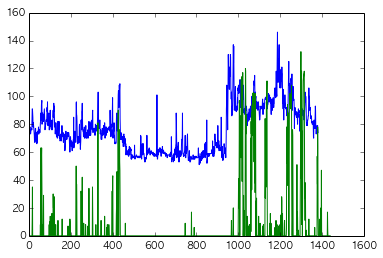

In [6]:
# 심장 박동 수와 걸을 걸이가 상관관계가 있는지 그래프를 통해 분석한다.
# 두 요소가 상관관계가 있음을 알 수 있다.
heart_json_df = json_normalize(heart_json[ u'activities-heart-intraday'][u'dataset'])
step_json_df = json_normalize(step_json[u'activities-steps-intraday'][u'dataset'])
step_json_df = step_json_df.rename(columns = {u'value':u'steps'})
heart_json_df = heart_json_df.rename(columns = {u'value': u'heart_beat'})
plt.plot(heart_json_df.index.tolist(), heart_json_df[u'heart_beat'].tolist())
plt.plot(step_json_df.index.tolist(), step_json_df[u'steps'].tolist())

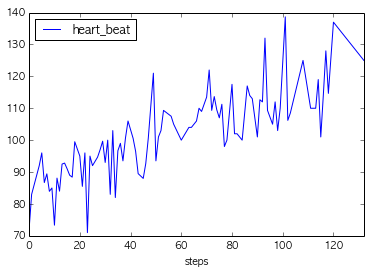

In [7]:
# 걸음 걸이 수에 해당하는 평균 심장박동 수를 구하면 선형 관계가 있음을 알 수 있다.
merge_data = step_json_df.merge(heart_json_df, left_on = u'time', right_on = u'time', how = 'outer')
step_per_heat = merge_data.groupby([u'steps']).mean()
step_per_heat.plot()

In [31]:
# 선형 회귀 모델을 만들 기 위해
# X축을 걸음 거리 수 Y축을 심장 박동 수로 구한다.
step_per_heat.to_csv('average_heart_beat_per_steps.csv')
dataset = pd.read_csv('average_heart_beat_per_steps.csv')
X = dataset[u'steps'].tolist()
Y = dataset[u'heart_beat'].tolist()

('Coefficients:', array([ 0.3500709]))
RMSE: 10.07
Variance score: -0.09


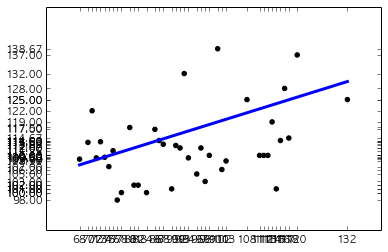

In [32]:
# 훈련 데이터셋과 검증 데이터셋을 나누어서 학습을 시킨다.
# 랜덤으로 섞어야 하나 이번 과제에서는 앞 부분과 뒷 부분으로 나누어서 쓴다.
# 실제로 결과가 앞 부분 데이터에 오버피팅 되는 것을 볼 수 있다. 그럭저럭 맞으므로 쓴다..
from sklearn import datasets
from sklearn.linear_model import LinearRegression
train_x, test_x = np.array(X[:-40]), np.array(X[-40:])
train_y, test_y = np.array(Y[:-40]), np.array(Y[-40:])
train_x = train_x.reshape(-1, 1)
test_x =test_x.reshape(-1, 1)
regr = LinearRegression()
regr.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((regr.predict(test_x) - test_y) ** 2)))
print('Variance score: %.2f' % regr.score(test_x, test_y))
plt.scatter(test_x, test_y,  color='black')
plt.plot(test_x, regr.predict(test_x), color='blue', linewidth=3)
plt.xticks(test_x)
plt.yticks(test_y)
plt.show()

In [10]:
sleep_json_df = json_normalize(sleep_json[u'sleep'][0][u'minuteData'])
sleep_json_df = sleep_json_df.rename(columns = {u'value':u'status'})
sleep_json_df = sleep_json_df.rename(columns = {u'dateTime':u'time'})

In [11]:
for t in range(len(sleep_json_df[u'time'])):
    sleep_json_df[u'time'][t] = sleep_json_df[u'time'][t].split(':')[0] + ':' + sleep_json_df[u'time'][t].split(':')[1] + u':00'

In [12]:
multiple_merge_data = merge_data.merge(sleep_json_df, left_on = u'time', right_on = u'time', how = 'outer')
multiple_merge_data.to_csv('multiple_data.csv')
step_json_df.to_csv('steps.csv')
sleep_json_df.to_csv('sleeps.csv')
heart_json_df.to_csv('hearts.csv')
for t in range(len(multiple_merge_data[u'status'])):
    if pd.isnull(multiple_merge_data[u'status'][t]):
        multiple_merge_data[u'status'][t] = 0

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
average_heat_pet_steps_with_status =  multiple_merge_data.groupby([u'steps', u'status']).mean()

In [14]:
average_heat_pet_steps_with_status.to_csv('average_heat_pet_steps_with_status.csv')

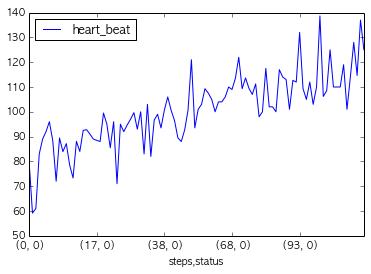

In [15]:
average_heat_pet_steps_with_status.plot()

In [16]:
multiple_dataset = pd.read_csv('average_heat_pet_steps_with_status.csv')
X1 = multiple_dataset[u'steps'].tolist()
X2 = multiple_dataset[u'status'].tolist()
Y = multiple_dataset[u'heart_beat'].tolist()
X = zip(X1, X2)

(2, 100)
('Coefficients:', array([  0.28745481, -12.95410182]))
RMSE: 7.82
Variance score: 0.71


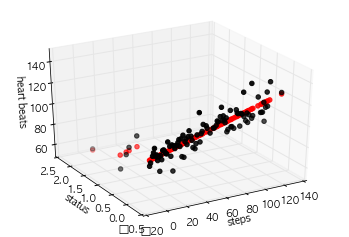

In [29]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import interactive
interactive(True)
train_x = np.array(X)
train_y = np.array(Y).T
print train_x.T.shape
regr = LinearRegression()
regr.fit(train_x, train_y)
print('Coefficients:', regr.coef_)
print("RMSE: %.2f" % np.sqrt(np.mean((regr.predict(train_x) - train_y) ** 2)))
print('Variance score: %.2f' % regr.score(train_x, train_y))
threed_graph = plt.figure().gca(projection='3d')
threed_graph.scatter(train_x.T[0].tolist(), train_x.T[1].tolist(),  regr.predict(train_x).tolist(),  color='red')
threed_graph.scatter(train_x.T[0].tolist(),  train_x.T[1].tolist(), train_y.tolist(),  color='black')
threed_graph.set_xlabel('steps')
threed_graph.set_ylabel('status')
threed_graph.set_zlabel('heart beats')
threed_graph.view_init(30, 240)
plt.draw()